[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bhumi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bhumi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bhumi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


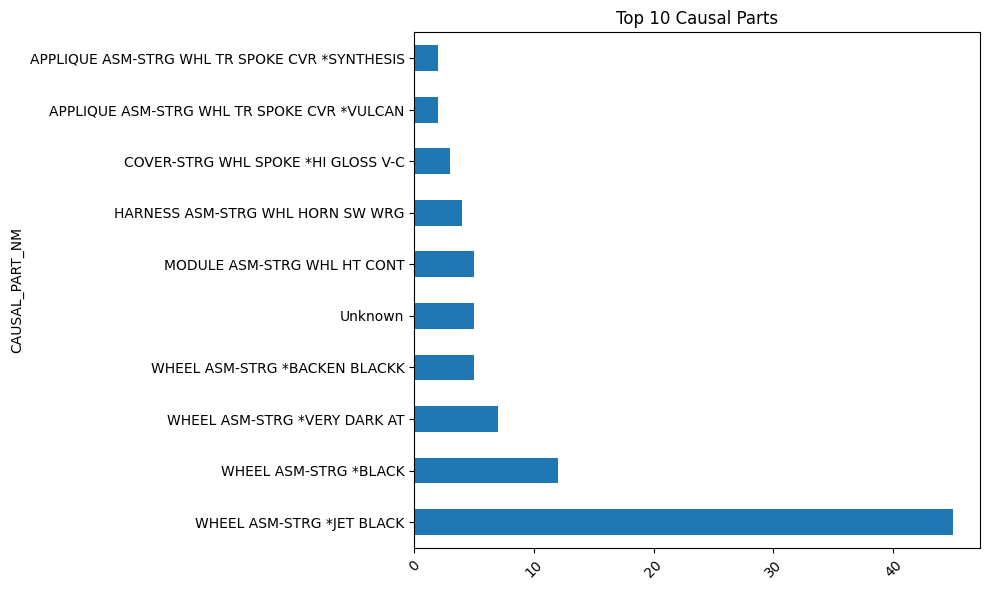

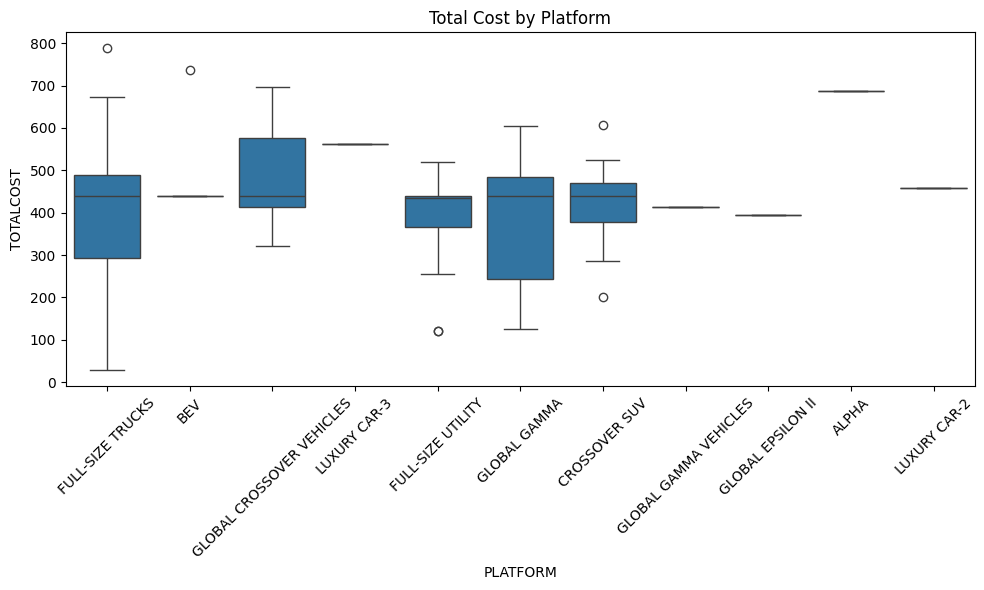

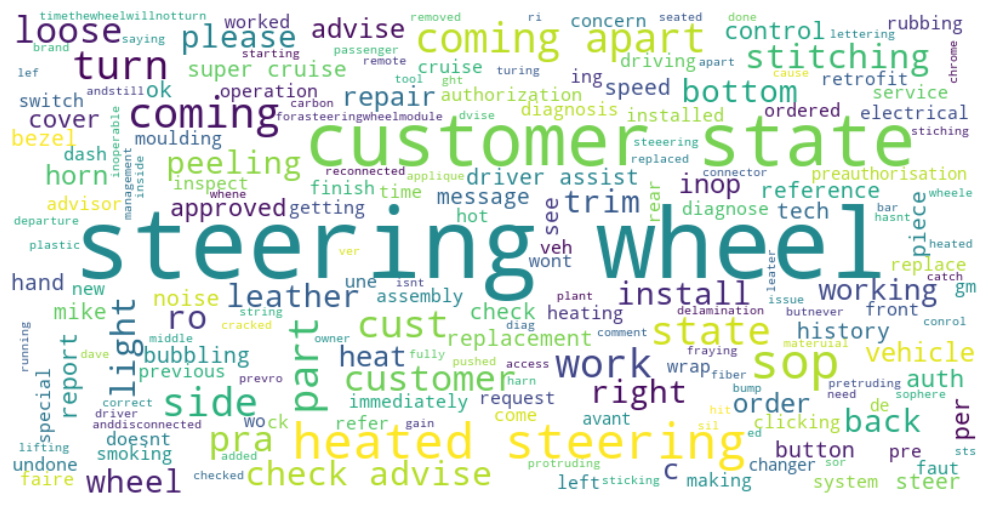

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import re
import os
from warnings import filterwarnings
filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


df=pd.read_excel("DA -Task 2..xlsx")

column_summary = []
for col in df.columns:
    summary = {
        "Column": col,
        "DataType": df[col].dtype,
        "UniqueValues": df[col].nunique(),
        "NullCount": df[col].isnull().sum()
    }
    if df[col].dtype == 'object':
        summary["TopCategories"] = df[col].value_counts().head(3).to_dict()
    elif np.issubdtype(df[col].dtype, np.number):
        summary["Stats"] = df[col].describe().to_dict()
    column_summary.append(summary)

df.drop(columns=["CAMPAIGN_NBR"], inplace=True)  

for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col].fillna("Unknown", inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

df['REPAIR_DATE'] = pd.to_datetime(df['REPAIR_DATE'], errors='coerce')

for col in ['PLATFORM', 'STATE', 'PLANT']:
    df[col] = df[col].astype(str).str.strip().str.upper()

for col in ['TOTALCOST', 'REPORTING_COST', 'LBRCOST', 'KM']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[col] = np.where((df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR), np.nan, df[col])
    df[col].fillna(df[col].median(), inplace=True)

plt.figure(figsize=(10, 6))
df['CAUSAL_PART_NM'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Causal Parts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("causal_parts_barplot.png")

plt.figure(figsize=(10, 6))
sns.boxplot(x='PLATFORM', y='TOTALCOST', data=df)
plt.title('Total Cost by Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("platform_cost_boxplot.png")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]
    return ' '.join(tokens)

df['CLEANED_TEXT'] = df['CUSTOMER_VERBATIM'].fillna("").apply(clean_text)

vectorizer = TfidfVectorizer(max_features=20)
X_tfidf = vectorizer.fit_transform(df['CLEANED_TEXT'])
tags = vectorizer.get_feature_names_out()
df['TAGS'] = df['CLEANED_TEXT'].apply(lambda x: [tag for tag in tags if tag in x])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['CLEANED_TEXT']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig("verbatim_wordcloud.png")

df.to_excel("cleaned_tagged_dataset.xlsx", index=False)
pd.DataFrame(column_summary).to_excel("column_analysis_summary.xlsx", index=False)


#### Get Top Tags

In [3]:
from collections import Counter
from itertools import chain
tag_counter = Counter(chain.from_iterable(df['TAGS']))
top_tags = tag_counter.most_common(20)

In [5]:
top_tags

[('steering', 88),
 ('wheel', 85),
 ('cust', 64),
 ('state', 58),
 ('customer', 55),
 ('coming', 25),
 ('part', 24),
 ('heated', 19),
 ('ro', 19),
 ('sop', 19),
 ('work', 15),
 ('apart', 13),
 ('advise', 12),
 ('check', 11),
 ('side', 11),
 ('turn', 10),
 ('pra', 9),
 ('loose', 9),
 ('stitching', 8),
 ('light', 7)]

In [11]:
from itertools import combinations
combo_counter = Counter()

for tag_list in df["TAGS"]:
    for combo in combinations(sorted(set(tag_list)), 2):  
        combo_counter[combo] += 1

top_combos = combo_counter.most_common(10)
top_combos

[(('steering', 'wheel'), 84),
 (('cust', 'steering'), 57),
 (('cust', 'state'), 56),
 (('cust', 'customer'), 55),
 (('cust', 'wheel'), 53),
 (('state', 'steering'), 53),
 (('customer', 'state'), 49),
 (('customer', 'steering'), 49),
 (('state', 'wheel'), 49),
 (('customer', 'wheel'), 45)]

# SUMMARY

### BONUS SECTIONS

###  **Summary of Tags Generated and Analysis**

**Tag Frequency Overview**  
From the analysis of the tag data:

- The most frequently occurring tags are:
  - **‘steering’ (88)** and **‘wheel’ (85)**: These dominate the dataset, implying that most issues or entries are directly related to the **steering wheel**.
  - **‘cust’ (64)** and **‘customer’ (55)**: Indicate heavy mention of the customer, which suggests that **customer-reported issues** are a major part of the dataset.
  - **‘state’ (58)**, **‘coming’ (25)**, **‘part’ (24)**, and **‘heated’ (19)** point to descriptions of **current status**, **future expected parts**, and specific features like **heated steering wheels**.
  - Tags like **‘ro’, ‘sop’, ‘loose’, ‘check’, ‘advise’, and ‘stitching’** reveal potential fault diagnostics, repair steps, and symptom-specific contexts.

**Top Tag Combinations**  
The most common pairings reinforce the frequency insights:
- **('steering', 'wheel') (84)**: Confirms steering wheel is the core component under scrutiny.
- High co-occurrences of:
  - **('cust', 'steering') (57)** and **('cust', 'wheel') (53)**: Emphasizes steering wheel issues directly reported or experienced by customers.
  - **('cust', 'state') (56)**, **('customer', 'state') (49)**: Suggest that records include **customer-observed statuses**.
  - Other combinations like **('customer', 'steering')** and **('state', 'wheel')** affirm a focus on **problem context** and **components' condition**.

---

###  **Insights Derived from the Dataset**

1. **Steering Wheel as a Critical Component**: The overwhelming recurrence of “steering” and “wheel” signals this is the primary pain point. Whether mechanical, cosmetic (like stitching), or feature-based (heated wheel), this component dominates service logs or customer feedback.

2. **High Customer Involvement**: The prevalence of 'cust' and 'customer' shows that **end-user feedback is a key data source**. Many tags describe perceived conditions ("loose", "heated", "not working")—underscoring the importance of capturing **subjective issue reporting**.

3. **Diagnostic and Repair Process Language**: Tags like 'advise', 'check', 'work', 'sop', and 'ro' (likely ‘repair order’) suggest **ongoing maintenance steps**, implying this data is used for **post-issue workflows**.

4. **Parts and Conditions**: Tags like 'part', 'loose', 'stitching', and 'light' hint at **component-level defects** or symptoms, which can be useful for **defect clustering** or **root cause analysis**.

---

### **Actionable Recommendations for Stakeholders**

1. **Prioritize Quality Control for Steering Components**
   - Given the high frequency of steering-related issues, initiate a **focused defect analysis** on steering wheel parts.
   - Investigate failures in heated features, stitching issues, and reports of loose parts.

2. **Train Service Agents on Key Symptoms and Terminology**
   - Use the tag combinations to build a **taxonomy of symptoms**, enabling faster and more consistent diagnosis by frontline staff.

3. **Develop Customer Sentiment Dashboards**
   - Leverage ‘cust’, ‘customer’, and status tags to build a **real-time alert system** based on the tone and frequency of issue reporting.
   - Use NLP to auto-classify severity based on context (e.g., “heated not working” vs. “loose steering”).

4. **Enhance Predictive Maintenance Strategies**
   - Combine tag frequencies with timestamps and service outcomes to **predict high-risk components** or recurring issues over time.
   - Focus on preemptive part replacements for commonly tagged components before failure occurs.

5. **Close the Feedback Loop**
   - Route common tag patterns to **engineering and design teams**. E.g., frequent ‘heated’ and ‘work’ tags suggest issues with electrical components that may require design revisions.



###  **Discrepancies in the Dataset**

#### 1. **Null Values**
- **Detection**: Your code explicitly checks for and logs null counts across all columns in the `column_summary`.
- **Columns like `CAMPAIGN_NBR`** were entirely null and dropped.
- Other columns with partial nulls were:
  - **Categorical** (e.g., `PLATFORM`, `STATE`, etc.): Filled with `"Unknown"`.
  - **Numerical** (e.g., `TOTALCOST`, `REPORTING_COST`, `LBRCOST`, `KM`): Filled using **median imputation**, a robust choice against outliers.

#### 2. **Missing or Implicit Primary Keys**
- No clear `primary key` column (like `REPAIR_ID` or `CASE_ID`) is mentioned or enforced in the code.
  - Suggests the dataset might not have a true unique identifier, or it’s embedded as a composite (e.g., `REPAIR_DATE` + `PLATFORM` + `CAUSAL_PART_NM`).
- This isn't explicitly handled in the code, but you could consider deriving a surrogate key using hashed combinations of relevant fields.

#### 3. **Outliers in Numeric Columns**
- **Outlier detection using IQR** on numerical columns:
  - Applied to `TOTALCOST`, `REPORTING_COST`, `LBRCOST`, and `KM`.
  - Outliers were replaced with `NaN`, then imputed with **median**.
  - Ensures distribution robustness and prevents skew from extreme values.

#### 4. **Inconsistent Formats**
- Categorical columns like `PLATFORM`, `STATE`, `PLANT` were **standardized** by:
  - Converting to string
  - Stripping whitespace
  - Applying uppercase formatting
- Prevents value duplication due to inconsistent casing or spacing.

#### 5. **Missing or Inconsistent Free-text**
- `CUSTOMER_VERBATIM` handled cautiously:
  - Missing texts filled with an empty string before text cleaning.
  - Normalized using lowercasing, lemmatization, and stopword removal for consistent tag extraction.

---

###  **Approach Summary**

| Discrepancy Type         | Resolution Strategy |
|--------------------------|---------------------|
| Null Columns             | Dropped (`CAMPAIGN_NBR`) |
| Partial Nulls (Categorical) | Filled with `"Unknown"` |
| Partial Nulls (Numerical)   | Replaced outliers with `NaN`, then filled with median |
| Missing Primary Key      | Not explicitly addressed – potential improvement area |
| Categorical Inconsistencies | Standardized using `.str.upper().strip()` |
| Textual Noise / Gaps     | Cleaned and tokenized using NLTK with fallback for nulls |
